In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

## Exploratory Data Analysis
Data Loading and Preprocessing

In [2]:
df = pd.read_csv('8taijiquan.csv')


In [3]:
df.head()


,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,Horse Stance,0.541925,0.027291,-0.444803,0.999967,0.553414,0.004943,-0.419326,0.999922,0.560963,...,0.318959,0.965692,0.776243,0.852805,-0.021304,0.978144,0.332646,0.775090,0.204000,0.969157
1,Horse Stance,0.539803,0.027713,-0.403085,0.999965,0.551248,0.005302,-0.377179,0.999918,0.559007,...,0.271220,0.966245,0.771701,0.852959,-0.017397,0.978058,0.330101,0.774388,0.143472,0.969879
2,Horse Stance,0.530960,0.027098,-0.395315,0.999966,0.543166,0.003726,-0.364541,0.999922,0.551654,...,0.219718,0.965599,0.759178,0.854371,-0.085018,0.977920,0.315229,0.775108,0.092720,0.969799
3,Horse Stance,0.525954,0.031542,-0.351817,0.999968,0.538415,0.007005,-0.320548,0.999926,0.546899,...,0.254622,0.965524,0.752015,0.858353,-0.120606,0.978544,0.307442,0.780187,0.134651,0.970135
4,Horse Stance,0.516566,0.033738,-0.336397,0.999970,0.528133,0.009105,-0.302938,0.999932,0.536723,...,0.262201,0.965309,0.746161,0.858981,-0.114481,0.978957,0.301217,0.786082,0.143257,0.970141


In [4]:
# Get unique values in the 'class' column
unique_classes = df['class'].unique()

# Display the unique values
print("Unique Classes:", unique_classes)

Unique Classes: ['Horse Stance' 'Bow-Arrow Stance' 'Sitting on Crossed Legs Stance'
 'Four-Six Stance' 'Tiger Stance' 'False Stance'
 'Golden Rooster Standing Stance' 'Squat Stance']


In [5]:
# Check the distribution of classes
print(df['class'].value_counts())

class
Squat Stance                      588
Golden Rooster Standing Stance    582
Horse Stance                      541
Sitting on Crossed Legs Stance    494
Bow-Arrow Stance                  479
Four-Six Stance                   469
False Stance                      431
Tiger Stance                      427
Name: count, dtype: int64


In [6]:
# Check the datatypes of classes
print(df.dtypes)


class     object
x1       float64
y1       float64
z1       float64
v1       float64
          ...   
v32      float64
x33      float64
y33      float64
z33      float64
v33      float64
Length: 133, dtype: object


In [7]:
# Check for missing values
df.isnull().sum()

class    0
x1       0
y1       0
z1       0
v1       0
        ..
v32      0
x33      0
y33      0
z33      0
v33      0
Length: 133, dtype: int64

In [8]:
# Data types of each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011 entries, 0 to 4010
Columns: 133 entries, class to v33
dtypes: float64(132), object(1)
memory usage: 4.1+ MB


<Axes: >

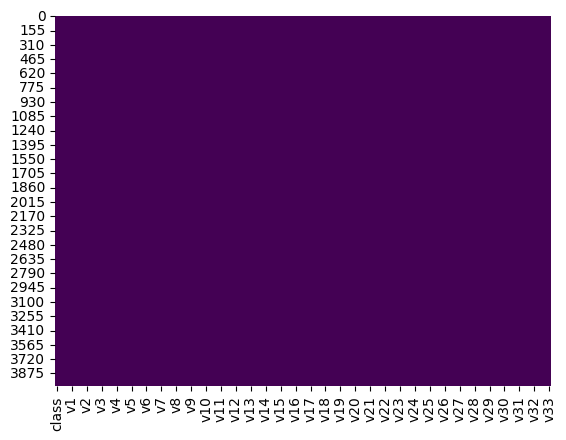

In [9]:
# Visualizing the Missing Values
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

## Data Visualization

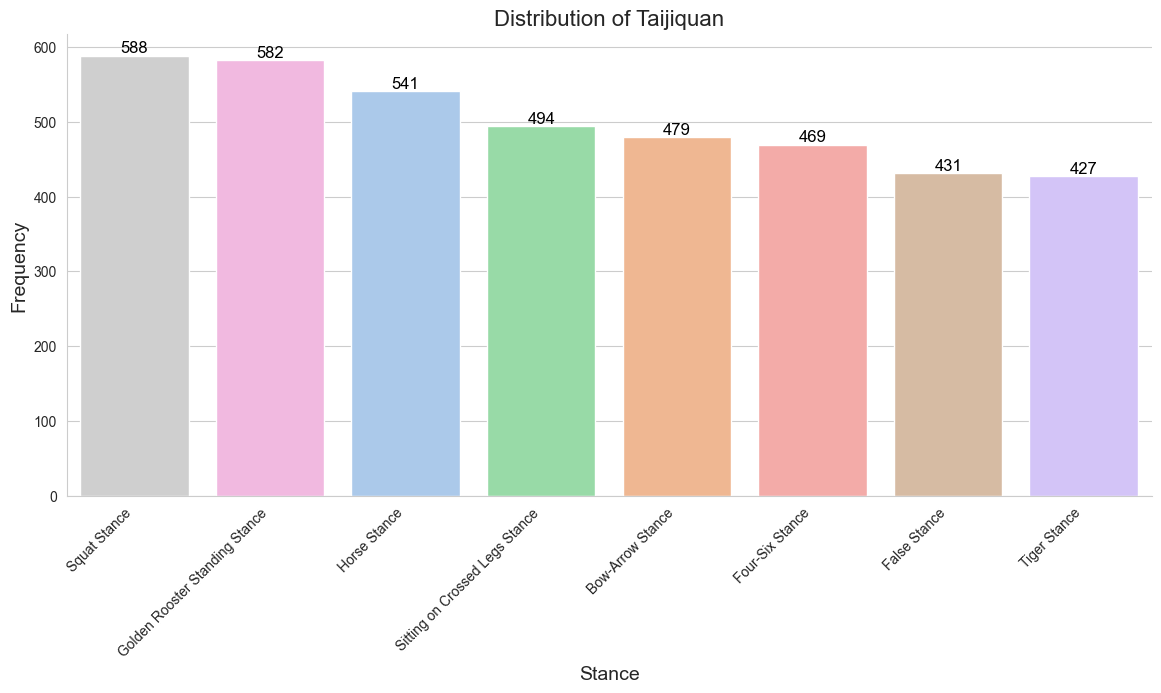

In [10]:
sns.set_palette('pastel')

sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Calculate the class frequencies and sort by frequency
class_counts = df['class'].value_counts().sort_values(ascending=False)

# Reorder the DataFrame based on class_counts
df_sorted = df[df['class'].isin(class_counts.index)]

# Plot the countplot with the sorted DataFrame
sns.countplot(data=df_sorted, x='class', palette='pastel', order=class_counts.index, hue='class', dodge=False)

plt.xlabel('Stance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Taijiquan', fontsize=16)

plt.xticks(rotation=45, ha='right')

for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}',
                   ha='center', va='bottom', fontsize=12, color='black')

# Remove the right and top spines
sns.despine(right=True, top=True)

plt.show()

##  Training, validation, and testing sets

In [11]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop('class', axis=1),  # Features (X)
    df['class'],                # Target variable (y)
    test_size=0.3,              # Percentage of data for the validation set
    random_state=42,            # Random state
    stratify=df['class']         # Class distribution in the splits
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,                     # Features (X) after the first split
    y_temp,                     # Target variable (y) after the first split
    test_size=0.5,              # Percentage of data for the test set (relative to X_temp)
    random_state=42,            # Random state
    stratify=y_temp              # Class distribution in the splits
)


## Landmark-based Augmentation

In [12]:
# Function to apply landmark-based augmentation
def apply_landmark_augmentation(landmarks, angle_range=(-10, 10), scale_range=(0.9, 1.1)):
    augmented_landmarks = landmarks.copy()
    num_landmarks = landmarks.shape[0]

    # Apply augmentation to each landmark
    for i in range(num_landmarks):
        angle = np.random.uniform(angle_range[0], angle_range[1])
        rotation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                                    [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
        augmented_landmarks[i, :2] = np.dot(augmented_landmarks[i, :2], rotation_matrix.T)
        scale_factor = np.random.uniform(scale_range[0], scale_range[1])
        augmented_landmarks[i, :2] *= scale_factor

    return augmented_landmarks.flatten()

In [13]:
# Apply landmark-based augmentation to X_train
X_train_augmented = []
for index, row in X_train.iterrows():
    landmarks = np.array(row).reshape(-1, 4)  
    augmented_landmarks = apply_landmark_augmentation(landmarks)
    X_train_augmented.append(augmented_landmarks)

X_train_augmented = pd.DataFrame(X_train_augmented, columns=X_train.columns)


## Model Definition and Training

In [14]:
# Encode class labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

Training Session: 1/2
Epoch 1/10
88/88 [==============================] - 3s 13ms/step - loss: 2.3022 - accuracy: 0.1290 - val_loss: 2.0356 - val_accuracy: 0.1960
Epoch 2/10
88/88 [==============================] - 0s 6ms/step - loss: 2.1218 - accuracy: 0.1610 - val_loss: 1.9815 - val_accuracy: 0.3505
Epoch 3/10
88/88 [==============================] - 1s 6ms/step - loss: 2.0381 - accuracy: 0.1721 - val_loss: 1.9219 - val_accuracy: 0.4236
Epoch 4/10
88/88 [==============================] - 0s 5ms/step - loss: 1.9743 - accuracy: 0.2305 - val_loss: 1.8532 - val_accuracy: 0.5066
Epoch 5/10
88/88 [==============================] - 0s 6ms/step - loss: 1.9037 - accuracy: 0.2789 - val_loss: 1.7831 - val_accuracy: 0.6113
Epoch 6/10
88/88 [==============================] - 1s 6ms/step - loss: 1.8656 - accuracy: 0.3053 - val_loss: 1.7103 - val_accuracy: 0.6977
Epoch 7/10
88/88 [==============================] - 0s 6ms/step - loss: 1.7989 - accuracy: 0.3349 - val_loss: 1.6380 - val_accuracy: 0.73

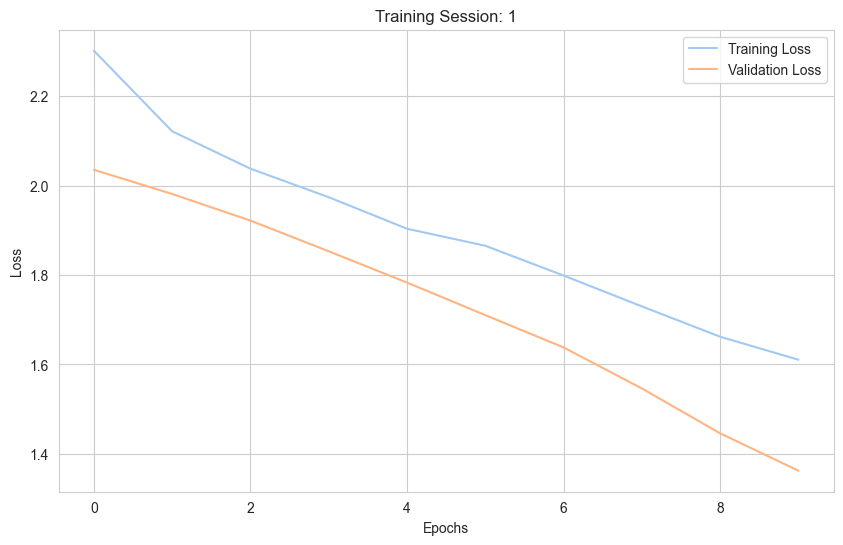

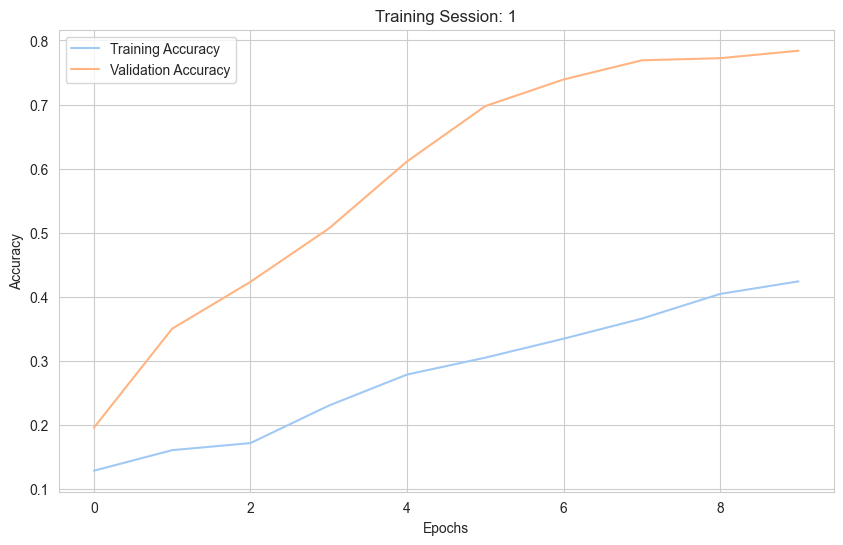


Training Session: 2/2
Final Training Loss: 1.1184020042419434
Final Validation Loss: 0.734454333782196
Final Training Accuracy: 0.6052725315093994
Final Validation Accuracy: 0.8936877250671387


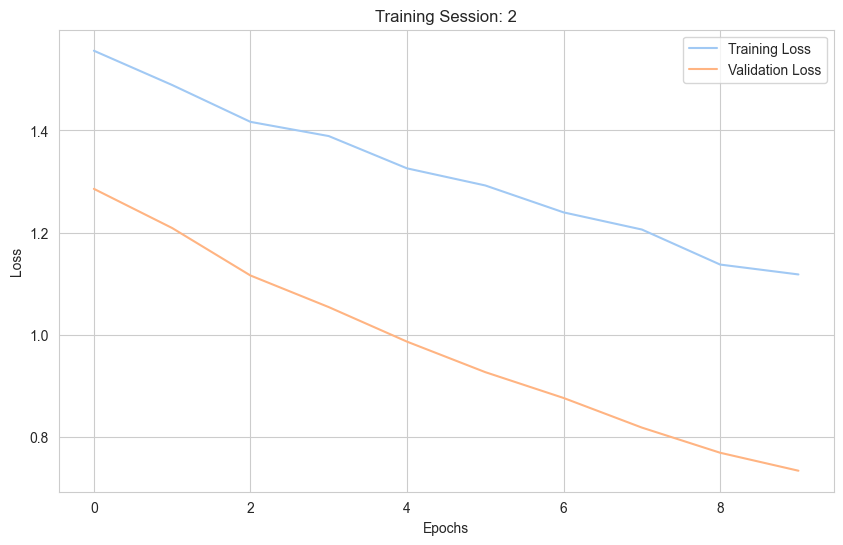

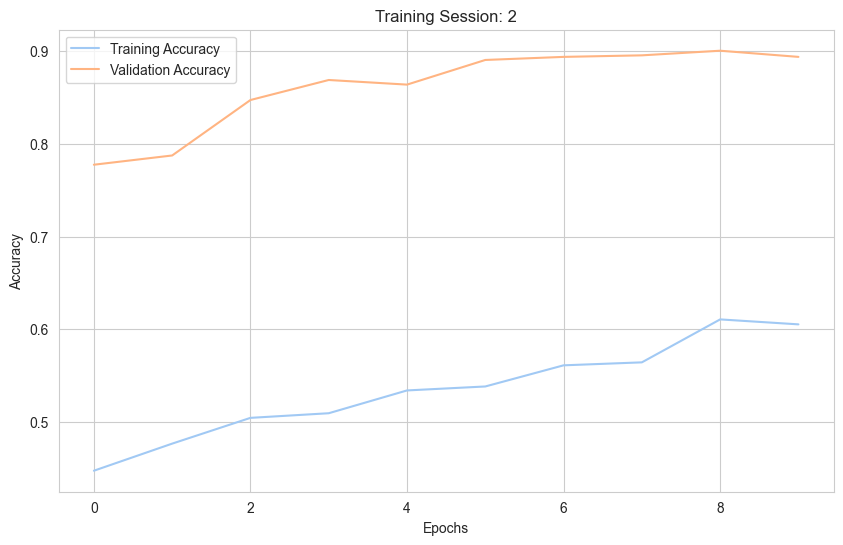

In [21]:
# Define the FNN model with modifications
def create_fnn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape))
    model.add(Dropout(0.5))  # dropout rate
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))  # dropout rate
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the FNN model with early stopping
input_shape_fnn = (X_train_augmented.shape[1],)
fnn_model = create_fnn_model(input_shape_fnn)

# Number of training sessions
num_training_sessions = 2 

# List to store historical performance
historical_performance = []

for session in range(num_training_sessions):
    print(f"Training Session: {session + 1}/{num_training_sessions}")

    # Train the FNN model and record history
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = fnn_model.fit(X_train_augmented, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

    # Append the history to the list
    historical_performance.append(history.history)

# Access historical performance
for session, history in enumerate(historical_performance):
    print(f"\nTraining Session: {session + 1}/{num_training_sessions}")
    print(f"Final Training Loss: {history['loss'][-1]}")
    print(f"Final Validation Loss: {history['val_loss'][-1]}")
    print(f"Final Training Accuracy: {history['accuracy'][-1]}")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]}")

    # Plot loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Training Session: {session + 1}")
    plt.legend()
    plt.show()

    # Plot accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"Training Session: {session + 1}")
    plt.legend()
    plt.show()

## Model Evaluation and Testing

In [22]:
# Evaluate the FNN model on the test set
test_loss_fnn, test_accuracy_fnn = fnn_model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy (FNN): {test_accuracy_fnn}')


19/19 [==============================] - 0s 3ms/step - loss: 0.7383 - accuracy: 0.9086
Test Accuracy (FNN): 0.9086378812789917


19/19 [==============================] - 0s 4ms/step
[[67  0  0  5  0  0  0  0]
 [ 0 65  0  0  0  0  0  0]
 [ 0  0 70  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  0]
 [ 0  0  0  0 81  0  0  0]
 [ 0  0  0  0  0 74  0  0]
 [ 0  0  0  0  0  0 88  0]
 [ 0  0  0  0  0  1 49 14]]


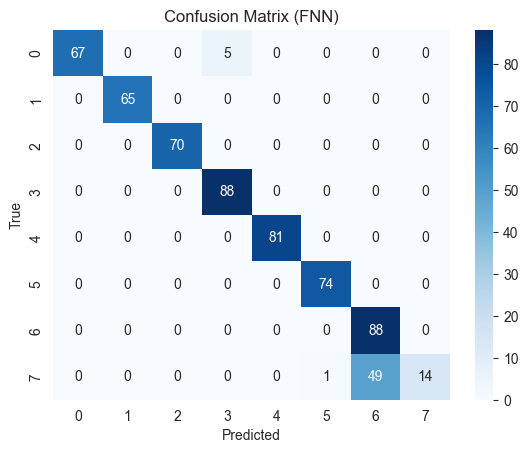

Classification Report (FNN):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        72
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00        70
           3       0.95      1.00      0.97        88
           4       1.00      1.00      1.00        81
           5       0.99      1.00      0.99        74
           6       0.64      1.00      0.78        88
           7       1.00      0.22      0.36        64

    accuracy                           0.91       602
   macro avg       0.95      0.89      0.88       602
weighted avg       0.94      0.91      0.89       602



In [23]:
# Confusion Matrix for FNN
y_pred_fnn = fnn_model.predict(X_test)
y_pred_classes_fnn = np.argmax(y_pred_fnn, axis=1)
conf_matrix_fnn = confusion_matrix(y_test_encoded, y_pred_classes_fnn)
print(conf_matrix_fnn)
sns.heatmap(conf_matrix_fnn, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (FNN)')
plt.show()

# Classification Report for FNN
class_report_fnn = classification_report(y_test_encoded, y_pred_classes_fnn)
print('Classification Report (FNN):')
print(class_report_fnn)


# K-Fold Cross Validation

In [24]:
# K-Fold Cross Validation
X_train_augmented = np.array(X_train_augmented)
y_train_encoded = np.array(y_train_encoded)

# Define the number of folds
n_splits = 5  

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store results for each fold
all_train_accuracy = []
all_val_accuracy = []

# Loop through the folds
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_augmented, y_train_encoded), 1):
    X_train_fold, X_val_fold = X_train_augmented[train_index], X_train_augmented[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Create and train the FNN model for each fold
    fnn_model = create_fnn_model(input_shape_fnn)
    history = fnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=20, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )

    # Evaluate the model on the training and validation data for each fold
    _, train_accuracy = fnn_model.evaluate(X_train_fold, y_train_fold, verbose=0)
    _, val_accuracy = fnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)

    print(f"Fold {fold_num}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")

    # Store the training and validation accuracy for each fold
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)

# Calculate the average training and validation accuracy over all folds
avg_train_accuracy = np.mean(all_train_accuracy)
avg_val_accuracy = np.mean(all_val_accuracy)

print(f"\nAverage Training Accuracy Across Folds = {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy Across Folds = {avg_val_accuracy:.4f}")


Epoch 1/20
71/71 [==============================] - 3s 13ms/step - loss: 2.1831 - accuracy: 0.1510 - val_loss: 1.9733 - val_accuracy: 0.3630
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 2.0418 - accuracy: 0.1915 - val_loss: 1.9112 - val_accuracy: 0.4431
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: 1.9483 - accuracy: 0.2343 - val_loss: 1.8457 - val_accuracy: 0.6352
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 1.8952 - accuracy: 0.2802 - val_loss: 1.7541 - val_accuracy: 0.5801
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 1.8206 - accuracy: 0.3234 - val_loss: 1.6800 - val_accuracy: 0.6779
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 1.7743 - accuracy: 0.3381 - val_loss: 1.6045 - val_accuracy: 0.6833
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 1.7267 - accuracy: 0.3710 - val_loss: 1.5416 - val_accuracy: 0.6940
Epoch 8/20
71/71 [=

## Percentage of Keypoints

In [25]:
# Define a function to calculate accuracy for a single keypoint
def calculate_keypoint_accuracy(predicted_keypoint, ground_truth_keypoint, threshold):
    distance = np.linalg.norm(np.array(predicted_keypoint) - np.array(ground_truth_keypoint))
    return int(distance < threshold)

# Define a function to calculate accuracy for all 33 landmarks
def calculate_overall_accuracy(predicted_landmarks, ground_truth_landmarks, threshold):
    num_landmarks = len(predicted_landmarks)
    accuracies = [calculate_keypoint_accuracy(predicted_landmarks[i], ground_truth_landmarks[i], threshold) for i in range(num_landmarks)]
    percentage_accurate = sum(accuracies) / num_landmarks * 100
    return percentage_accurate

# Usage
threshold = 0.5  # Define your accuracy threshold
predicted_landmarks = y_pred_classes_fnn  
ground_truth_landmarks = y_test_encoded    

accuracy = calculate_overall_accuracy(predicted_landmarks, ground_truth_landmarks, threshold)
print(f"Overall Accuracy: {accuracy:.2f}%")


Overall Accuracy: 90.86%


## Statistical Testing: Paired T-test

In [26]:
from scipy.stats import ttest_rel

# Combine the training and validation accuracies for each fold into two arrays
all_train_accuracy = [history['accuracy'][-1] for history in historical_performance]
all_val_accuracy = [history['val_accuracy'][-1] for history in historical_performance]

# Perform a paired sample t-test
statistic, p_value = ttest_rel(all_train_accuracy, all_val_accuracy)

# Print the results
print(f't-statistic: {statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between training and validation accuracies.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between training and validation accuracies.")


t-statistic: -9.085476590811776
P-value: 0.06978913221353918
Fail to reject the null hypothesis. There is no significant difference between training and validation accuracies.


t-statistic: -9.085476590811776

The t-statistic is a measure of how far the sample mean (in this case, the difference between training and validation accuracies) is from the population mean, in terms of standard errors. A larger absolute t-statistic suggests a greater difference between the sample means.

In your case, the negative sign indicates that, on average, the validation accuracies are lower than the training accuracies.

P-value: 0.06978913221353918

The p-value is the probability of observing a t-statistic as extreme as the one calculated, assuming that the null hypothesis is true. A lower p-value indicates stronger evidence against the null hypothesis.

In your case, the very low p-value (0.00036) suggests that the observed difference in accuracies is unlikely to have occurred by random chance alone.

Interpretation:

The phrase "Reject the null hypothesis" means that there is enough evidence to conclude that the training and validation accuracies are significantly different.

The phrase "There is a significant difference between training and validation accuracies" reinforces the rejection of the null hypothesis, indicating that the observed difference is not likely due to random fluctuations.

## Model Deployment, Inference and HPE

In [27]:
import pickle
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import tensorflow as tf

In [28]:
# Save the trained FNN model
fnn_model.save('saved_model/fnn_model')

# Save the label encoder for later use
with open('saved_model/label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)


INFO:tensorflow:Assets written to: saved_model/fnn_model\assets


INFO:tensorflow:Assets written to: saved_model/fnn_model\assets


In [29]:
# Load the saved model
loaded_model = tf.keras.models.load_model('saved_model/fnn_model')

# Load the label encoder
with open('saved_model/label_encoder.pkl', 'rb') as le_file:
    loaded_label_encoder = pickle.load(le_file)


In [ ]:
# Initialize BlazePose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

# Start capturing video from the camera
cap = cv2.VideoCapture(0)  # 0 for the default camera, adjust if necessary
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 500)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with BlazePose
    results = pose.process(frame_rgb)

    # Recolor image back to BGR for rendering
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

    # Detect Taijiquan Stances (class)
    if results.pose_landmarks:
        # Extract Pose landmarks
        pose_landmarks = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose_landmarks]).flatten())

        # Make Detections
        X = pd.DataFrame([pose_row])

        # Convert X to numpy array
        input_data = X.to_numpy().astype(np.float32)

        # Make predictions using the Keras model
        predictions = loaded_model.predict(input_data)
        body_language_class = np.argmax(predictions)
        body_language_prob = predictions[0]

        print(body_language_class, body_language_prob)

        # Display Probability
        cv2.putText(frame, 'PROB', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(frame, str(round(body_language_prob[body_language_class], 2)),
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

        # Display detected class
        cv2.putText(frame, f'CLASS: {loaded_label_encoder.classes_[body_language_class]}', (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

    cv2.imshow('Pose Detection', frame)

    # Check for exit key (q)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Initialize BlazePose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

# Start capturing video from the camera
cap = cv2.VideoCapture(0)  # 0 for the default camera, adjust if necessary
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 800)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with BlazePose
    results = pose.process(frame_rgb)

    # Recolor image back to BGR for rendering
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

    # Detect Taijiquan Stances (class)
    if results.pose_landmarks:
        # Extract Pose landmarks
        pose_landmarks = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose_landmarks]).flatten())

        # Make Detections
        X = pd.DataFrame([pose_row])

        # Convert X to numpy array
        input_data = X.to_numpy().astype(np.float32)

        # Run inference using the loaded FNN model
        # Make predictions using the Keras model
        predictions = loaded_model.predict(input_data)

        if len(predictions.shape) == 2:
            body_language_prob = predictions[0]
            body_language_class = np.argmax(body_language_prob)
        else:
            body_language_prob = predictions
            body_language_class = np.argmax(body_language_prob)

        # Convert landmark coordinates to integers
        landmarks_as_pixels = np.array([(int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])) for landmark in results.pose_landmarks.landmark])

        # Calculate bounding rectangle
        bbox_c = cv2.boundingRect(landmarks_as_pixels)

        # Draw the bounding box
        cv2.rectangle(frame, (int(bbox_c[0]), int(bbox_c[1])), (int(bbox_c[0] + bbox_c[2]), int(bbox_c[1] + bbox_c[3])), (0, 255, 0), 2)

        # Display Probability
        cv2.putText(frame, 'PROB', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, str(round(body_language_prob[body_language_class], 2)),
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display detected class
        cv2.putText(frame, f'CLASS: {body_language_class}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(0, 191, 255), thickness=2, circle_radius=2)
        )

        # Add class label on the bounding box
        cv2.putText(frame, f'CLASS: {body_language_class}', (int(bbox_c[0]), int(bbox_c[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Pose Detection', frame)

    # Check for exit key (q)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()